# UW-Madison GI Tract Image Segmentation

## Inference

In [14]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.options.plotting.backend = "plotly"
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import os
import re
import cv2
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
from matplotlib.colors import LinearSegmentedColormap
import plotly
import PIL
import cv2

# Import Tensorflow and Keras
from tensorflow import keras
import tensorflow as tf

from keras.models import load_model


		– MATPLOTLIB VERSION: 3.5.2


In [121]:
%cd 'hpc_train_files'

[Errno 2] No such file or directory: 'hpc_train_files'
/Users/viktor/Documents/BA/GIT/HealthyOrganTracker/hpc_train_files


In [3]:
from config import CFG
from dataloader import DataGenerator
from loss import dice_coef, iou_coef, dice_loss, bce_dice_loss, iou_coef_per_class
from datapreparation import extract_metadata, remove_faulties

## Config ⚙️


In [4]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'
STYE = "multilabel"
DEBUG = True

"""
Backbones available: 
        'efficientnetb0'
        'efficientnetb5'
        'efficientnetb7'
        'inceptionresnetv2'
        'inceptionv3'
        'resnet50'
        'resnext50'
        'resnext101'
        'seresnext50'
        'seresnext101'
        'densenet121'
        'densenet201'
        """

"\nBackbones available: \n        'efficientnetb0'\n        'efficientnetb5'\n        'efficientnetb7'\n        'inceptionresnetv2'\n        'inceptionv3'\n        'resnet50'\n        'resnext50'\n        'resnext101'\n        'seresnext50'\n        'seresnext101'\n        'densenet121'\n        'densenet201'\n        "

In [5]:
df = pd.read_csv(TRAIN_CSV)
#df = df.sample(n=90, random_state=1)

In [6]:
cfg = CFG(
    backbone            = 'efficientnetb0',
    img_dims            = (256,256,3),
    model               = 'UNet',
    batch_size          = 16, 
    epochs              = 1, 
    kaggle              = False, 
    use_fold_csv        = True,
    semi3d_data         = False,
    remove_faulty_cases = True,
    use_crop_data       = False)

In [109]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=True):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/255.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)

# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


## Load Dataframe with crop infos

In [110]:
df_train = extract_metadata(df, TRAIN_DIR, channels=3, stride=2)
df_train.sample(5)

Frame merged. Shape: (38496, 21)
Remove faulty cases: True
Sucess. Shape: (38208, 21)


,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,...,pixel_y,count,path00,path01,path02,image_paths,rs,re,cs,ce
19775,case89_day19_slice_0064,32263 8 32623 13 32982 16 33342 17 33702 19 34...,,45931 15 46289 19 46647 23 47006 25 47365 27 4...,89,19,64,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,1.50,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,62,10000,0,360
3484,case19_day0_slice_0029,,,,19,0,29,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,42,10000,0,317
29674,case131_day0_slice_0123,,,,131,0,123,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,101,10000,0,329
8495,case40_day0_slice_0016,,,,40,0,16,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,34,10000,0,266
4644,case22_day0_slice_0037,,,,22,0,37,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,63,10000,0,223


## Generate Original Masks

In [9]:
IMAGE_SHAPE = SEG_SHAPE = (224,224)

def make_seg_mask(row, output_dir, resize_to, resize=False):
    """"""
    _slice_shape = (row.height, row.width)
    counter  = 0
    
    if not pd.isna(row.large_bowel):
        lb_mask = rle_decode(row.large_bowel, _slice_shape)
    else:
        lb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.small_bowel):
        sb_mask = rle_decode(row.small_bowel, _slice_shape)
    else:
        sb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.stomach):
        st_mask = rle_decode(row.stomach, _slice_shape)
    else:
        st_mask = np.zeros(_slice_shape)
        counter +=1
    
    mask_arr = np.stack([lb_mask, sb_mask, st_mask], axis=-1)
    
    if resize:
        mask_arr = cv2.resize(mask_arr, resize_to, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
            
    mask_path = os.path.join(output_dir, f"{row.id}_mask.png")
    if counter != 3:
        cv2.imwrite(mask_path, mask_arr)
        
    return mask_path

## Plot Masks Helper


In [10]:

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

In [11]:
outputdir = os.path.join(BASE_PATH, "masks")
outputdir

'input/uw-madison-gi-tract-image-segmentation/masks'

In [111]:
DEBUG = False
if DEBUG:
    df_train["multilabel_mask_path"] = df_train.progress_apply(lambda _row: make_seg_mask(_row, outputdir, resize_to=SEG_SHAPE, resize=False), axis=1)
    df_train.to_csv("df_train_with_mask_paths.csv", index=False)

df_train = pd.read_csv("df_train_with_mask_paths.csv")
df_train.fillna('', inplace=True)

In [113]:
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,...,count,path00,path01,path02,image_paths,rs,re,cs,ce,multilabel_mask_path
12488,case54_day35_slice_0121,,,,54,35,121,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,62,10000,0,249,input/uw-madison-gi-tract-image-segmentation/m...
19275,case88_day36_slice_0140,,,,88,36,140,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,45,10000,0,360,input/uw-madison-gi-tract-image-segmentation/m...
11555,case49_day13_slice_0052,,,,49,13,52,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,0,10000,0,357,input/uw-madison-gi-tract-image-segmentation/m...
5732,case30_day0_slice_0117,16924 14 17188 20 17453 23 17719 24 17985 26 1...,20955 7 21219 10 21484 13 21750 14 22015 16 22...,16624 5 16882 29 17145 35 17409 38 17674 40 17...,30,0,117,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,3,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,48,10000,0,263,input/uw-madison-gi-tract-image-segmentation/m...
24302,case116_day0_slice_0047,,,,116,0,47,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,73,10000,0,334,input/uw-madison-gi-tract-image-segmentation/m...


## Visualiize

In [114]:
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Large Bowel", "Small Bowel", "Stomach"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [115]:
def mask_from_segmentation(segmentation, shape):
    '''Returns the mask corresponding to the inputed segmentation.
    segmentation: a list of start points and lengths in this order
    max_shape: the shape to be taken by the mask
    return:: a 2D mask'''

    # Get a list of numbers from the initial segmentation
    segm = np.asarray(segmentation.split(), dtype=int)

    # Get start point and length between points
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    # Compute the location of each endpoint
    end_point = start_point + length_point

    # Create an empty list mask the size of the original image
    # take onl
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Change pixels from 0 to 1 that are within the segmentation
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

In [116]:
def get_id_mask(ID, train, verbose=False):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask'''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train[train["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data[k] for k in ["large_bowel", "small_bowel", "stomach"]]
    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = ID_data['height'].values[0]
    max_width = ID_data['width'].values[0]
    
    if ID_data['count'].values[0] == 0:
        max_height = max_width = 0

    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = ID_data[location].values[0]
            segmentation = observation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

    # If no segmentation was found skip
    elif max_segmentation == 0:
        mask = None
        if verbose:
            print("None of the classes have segmentation.")
            
    return mask

In [117]:
def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    plt.show()
def get_overlay(img, mask, _alpha=0.999, _beta=0.45, _gamma=0):
    
    # Normalize to be between 0-1 (float32)
    img = (img/img.max()).astype(np.float32)
    

    mask_rgb=mask.astype(np.float32)
    
    # overlay
    seg_overlay = cv2.addWeighted(src1=img, alpha=_alpha, 
                                  src2=mask_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def get_miss_overlay(gt_mask, pred_mask, _alpha=0.9, _beta=0.25, _gamma=0):
    
    # Make mask RGB and float32
    miss_rgb = np.zeros((*pred_mask.shape[:2],3), dtype=np.float32)
    
    if len(pred_mask.shape)==2:
        miss_rgb[..., 1] = np.where((gt_mask==pred_mask)&(gt_mask!=0), 0.8, 0.0)
        miss_rgb[..., 0] = np.where((gt_mask!=pred_mask), 0.8, 0.0)
    else:
        
        miss_rgb = np.where((gt_mask==pred_mask)&(gt_mask!=0.0), (0.0,0.8,0.0), (0.0,0.0,0.0))
        miss_rgb = np.where((gt_mask!=pred_mask), (0.8,0.0,0.0), miss_rgb)
        
    return miss_rgb

def plot_preds(img, pred_mask, gt_mask):
    gt_overlay = get_overlay(img, gt_mask)
    pred_overlay = get_overlay(img, pred_mask)
    miss_overlay = get_miss_overlay(gt_mask, pred_mask)
    
    plt.figure(figsize=(20,12))
    
    for i, (_desc, _img) in enumerate(zip(["Original", "Prediction Mask", "Ground-Truth Mask", "Miss Mask"], [img, pred_overlay, gt_overlay, miss_overlay])):        
        plt.subplot(1,4,i+1)
        plt.imshow(_img)
        plt.title(f"{_desc} Image", fontweight="bold")        
        plt.axis(False)
        
        if i in [1,2]:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
            labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
            plt.legend(handles,labels)
        elif i==3:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.0,0.8,0.0), (0.8,0.0,0.0), (0.0, 0.0, 0.0)]]
            labels = ["Agreement", "Disagreement", "Background"]
            plt.legend(handles,labels)
    plt.tight_layout()
    plt.show()


In [23]:
from glob import glob

def get_performance_from_history_df(path="tensorboard_logs/", output="all_histories.csv", extra_regex=False):
    if not extra_regex:
        all_histories = pd.DataFrame(columns=['Encoder','Größe' ,'Beste Epoche', 'Loss', 'Val. loss', 'Dice', 'Val. Dice', 'IoU', 'Val. IoU'])
    else:
        all_histories = pd.DataFrame(columns=['Encoder','Größe' ,'Beste Epoche', 'Loss', 'Val. loss', 'Dice', 'Val. Dice', 'IoU', 'Val. IoU', '2.5D', 'Crop', 'Batch Size', 'Epochen'])

    # Iterate over every historyFold3.csv in tensorboard_logs/base_BS_16_no_add_ons/subfolder and plot each column values with plotly and mark the maximum value and drop the first column
    for file in glob(os.path.join(path, "**", "*.csv"), recursive=True):
        if file.endswith(".csv"):
            print(file)
            history_df = pd.read_csv(file, index_col=0)

            regexBone = 'None' if not re.search("BB_(\w+)_D",path) else re.search("BB_(\w+)_D",path).group(1) 
            regexDim = 'None' if not re.search("DIM_\((\d+),",path) else re.search("BB_(\w+)_D",path).group(1) 
            threeDim = 'None' if not re.search("SEMI3D_([aA-zZ]{4,5})_",path) else re.search("BB_(\w+)_D",path).group(1) 
            regexCrop = 'None' if not re.search("CROPDATA_([aA-zZ]{4,5})_",path) else re.search("BB_(\w+)_D",path).group(1) 
            regexBatch = 'None' if not re.search("BATCH_(\d+)_",path) else re.search("BB_(\w+)_D",path).group(1) 
            regexEpochs = 'None' if not re.search("EPOCHS_(\d+)_",path) else re.search("BB_(\w+)_D",path).group(1)

            best_epoch = history_df[history_df["val_loss"]==history_df["val_loss"].min()].index.values[0]

            loss = history_df.loc[best_epoch, 'loss']
            val_loss = history_df.loc[best_epoch, 'val_loss']

            dice_coef = history_df.loc[best_epoch, 'dice_coef']
            val_dice_coef = history_df.loc[best_epoch, 'val_dice_coef']

            iou_coef = history_df.loc[best_epoch, 'iou_coef']
            val_iou_coef = history_df.loc[best_epoch, 'val_iou_coef']

            if not extra_regex:
                all_histories = all_histories.append({'Encoder':regexBone, 'Größe':regexDim, 'Beste Epoche':best_epoch, 'Loss':loss, 'Val. loss':val_loss, 'Dice':dice_coef, 'Val. Dice':val_dice_coef, 'IoU':iou_coef, 'Val. IoU':val_iou_coef}, ignore_index=True)
            else:
                all_histories = all_histories.append({'Encoder':regexBone, 'Größe':regexDim, 'Beste Epoch':best_epoch, 'Loss':loss, 'Val. loss':val_loss, 'Dice':dice_coef, 'Val. Dice':val_dice_coef, 'IoU':iou_coef, 'Val. IoU':val_iou_coef, '2.5D':threeDim, 'Crop':regexCrop, 'Batch Size':regexBatch, 'Epochen':regexEpochs}, ignore_index=True)


    all_histories.to_csv(output)

    return all_histories


def get_best_epoch(history_df):
    return history_df[history_df["val_loss"]==history_df["val_loss"].min()].index.values[0]

def print_best_epoch(history_df):
    best_epoch = get_best_epoch(history_df)
    print(f"Best epoch: {best_epoch}")
    print(f"Best loss: {history_df.loc[best_epoch, 'val_loss']}")



In [24]:
efb2_hist = getPerformanceFromHistoryDf(path="tensorboard_logs/efb2_trains/batch_size_32/res_256", output="all_histories_efb2_256.csv")

tensorboard_logs/efb2_trains/batch_size_32/res_256/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_32_EPOCHS_50_FOLD_3.h5_16082022-0504_FOLD_3/historyFold3.csv
tensorboard_logs/efb2_trains/batch_size_32/res_256/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_32_EPOCHS_50_FOLD_3.h5_16082022-0504_FOLD_3/historyFold3.csv
tensorboard_logs/efb2_trains/batch_size_32/res_256/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_32_EPOCHS_50_FOLD_3.h5_16082022-0505_FOLD_3/historyFold3.csv


In [31]:
path="tensorboard_logs/efb2_trains/batch_size_32/res_256/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_32_EPOCHS_50_FOLD_3.h5_16082022-0504_FOLD_3/historyFold3.csv"

regexBone = "None" if not re.search("BB_(\w+)_D",path) else re.search("BB_(\w+)_D",path).group(1) 
regexBone

'efficientnetb2'

In [25]:
print_history_latex(efb2_hist)

\begin{tabular}{lllllllll}
\toprule
       Encoder & Größe & Beste Epoche &   Loss & Val. loss &   Dice & Val. Dice &    IoU & Val. IoU \\
\midrule
efficientnetb2 &   256 &           49 & 0.0245 &    0.1032 & 0.9434 &    0.7727 & 0.9406 &   0.8177 \\
efficientnetb2 &   256 &           46 & 0.0252 &    0.1052 & 0.9419 &    0.7651 & 0.9394 &   0.8289 \\
efficientnetb2 &   256 &           27 & 0.0323 &    0.1391 & 0.9251 &    0.6798 & 0.9121 &   0.8130 \\
\bottomrule
\end{tabular}



In [24]:
# ~~~ Get the data ~~~
ID = "case123_day20_slice_0107"
# Get the portion of dataframe where we have ONLY the speciffied ID
ID_data = df_train[df_train["id"]==ID].reset_index(drop=True)
ID_data

,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,...,count,path00,path01,path02,image_paths,rs,re,cs,ce,multilabel_mask_path
0,case123_day20_slice_0107,11844 6 12107 13 12368 20 12633 23 12898 25 13...,17995 4 18256 11 18518 15 18781 19 19043 23 19...,,123,20,107,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,22,10000,0,261,input/uw-madison-gi-tract-image-segmentation/m...


In [26]:
history_df = pd.read_csv("historyFold3.csv", index_col=0)

# Get the epoch number with the highest val_loss
best_epoch = history_df[history_df["val_loss"]==history_df["val_loss"].min()].index.values[0]

# print best epoch and loss
print(f"Best epoch: {best_epoch}")
print(f"Best loss: {history_df.loc[best_epoch, 'val_loss']}")


Best epoch: 43
Best loss: 0.1552976965904235


In [21]:
def print_history_latex(history_df):
    history_df = history_df.sort_values(by=['Val. Dice'], ascending=False)
    history_df

    print(history_df.to_latex(index=False , float_format=lambda x: '{:.4f}'.format(x)))

In [91]:
min_pandas = all_histories.min(1)
def f_tex(x):
    if x in min_pandas.values:
        return '\\textbf{' +f'{x:0.4f}'+ '}'
    elif isinstance(x, str) or isinstance(x, int):
        return x
    else:
        return f'{x:0.4f}'
    
latex = all_histories.to_latex(bold_rows =True,  index=False, escape = False,
                formatters = [f_tex]*len(all_histories.columns))

print(latex)

\begin{tabular}{llllllll}
\toprule
       Encoder & Beste Epoche &      Loss & Val. loss &      Dice & Val. Dice &       IoU &  Val. IoU \\
\midrule
efficientnetb7 &           14 &  0.050004 &  0.106429 &  0.884793 &  0.763633 &  0.815339 &  0.822273 \\
efficientnetb2 &           22 &  0.036894 &  0.112293 &  0.914579 &  0.748865 &  0.903746 &  0.819461 \\
efficientnetb1 &           18 &  0.042502 &  0.115788 &  0.901794 &  0.738554 &  0.888943 &  0.817924 \\
efficientnetb5 &           25 &  0.036911 &  0.116006 &  0.914612 &  0.737783 &  0.908867 &  0.816061 \\
   inceptionv3 &           30 &  0.038114 &  0.118555 &  0.911824 &  0.732622 &   0.89372 &  0.810752 \\
efficientnetb3 &           22 &  0.038154 &  0.118103 &  0.911667 &  0.732374 &  0.895789 &  0.820608 \\
   densenet121 &           33 &  0.038502 &  0.119762 &  0.910922 &  0.730003 &  0.887278 &  0.809293 \\
efficientnetb6 &           19 &  0.040089 &  0.119415 &  0.907297 &   0.72768 &  0.892501 &  0.824028 \\
efficientne

In [59]:
file = "tensorboard_logs/base_BS_16_no_add_ons/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_BATCH_16_EPOCHS_50_FOLD_3.h5_15082022-2108_FOLD_3/historyFold3.csv"

regexBone = re.search("BB_(\w+)_D",file).group(1)
backbone = file.split("/")[-2]

# print both 
print(f"Bone: {regexBone}")

Bone: efficientnetb2


In [27]:
class FixedDropout(keras.layers.Dropout):
    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)

custom_objects = custom_objects={
    'FixedDropout': FixedDropout,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss  
}

In [42]:
df_train['fold'] = pd.read_csv('fold.csv')['fold']
valid_ids = df_train[df_train["fold"]==3].index
df_val = df_train.loc[valid_ids]
val_generator = DataGenerator(df_train.loc[valid_ids], height=cfg.height, width=cfg.width, semi3d_data=cfg.semi3d_data)
num_batches = int(len(df_train.loc[valid_ids])/cfg.batch_size)

In [29]:
# load model.h5 and get predictions for val_generator and plot accuracy of each class


for model_path in glob(os.path.join("../tensorboard_logs/base_BS_16_no_add_ons", "*", "model.h5")):
    # print(model_path)
    continue

model_path = "../tensorboard_logs/base_BS_16_no_add_ons/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_BATCH_16_EPOCHS_50_FOLD_3.h5_15082022-2108_FOLD_3/model.h5"
model = load_model(model_path, custom_objects=custom_objects)
preds = model.predict(val_generator)
# lot_preds(val_generator.imgs, preds, val_generator.masks)

2022-08-17 02:25:00.584446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-17 02:25:00.584621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5300M

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB



2022-08-17 02:25:07.152144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


497/497 [==============================] - 242s 481ms/step


In [49]:
df_val[df_val['id'] == "case18_day19_slice_0065"]['id'].values[0]

'case18_day19_slice_0065'

In [53]:
ex = df_val[df_val['id'] == "case18_day19_slice_0065"]
ex.index.values[0]

3088

In [ ]:
# Full Example
ex = df_val[df_val['id'] == "case18_day19_slice_0065"]
id = ex['id'].values[0]

iou = iou_coef_per_class(preds[0], )

img_path = df_train[df_train['id'] == ID]['path'].values[0]
mask_path = df_train[df_train['id'] == ID]['multilabel_mask_path'].values[0]

# Read image
img = open_gray16(img_path, normalize=True, to_rgb=True)
img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
mask = get_id_mask(ID,df_train, verbose=False)
pred = np.zeros(img.shape )
# Get mask


In [ ]:
mask_path

'input/uw-madison-gi-tract-image-segmentation/masks/case123_day20_slice_0107_mask.png'

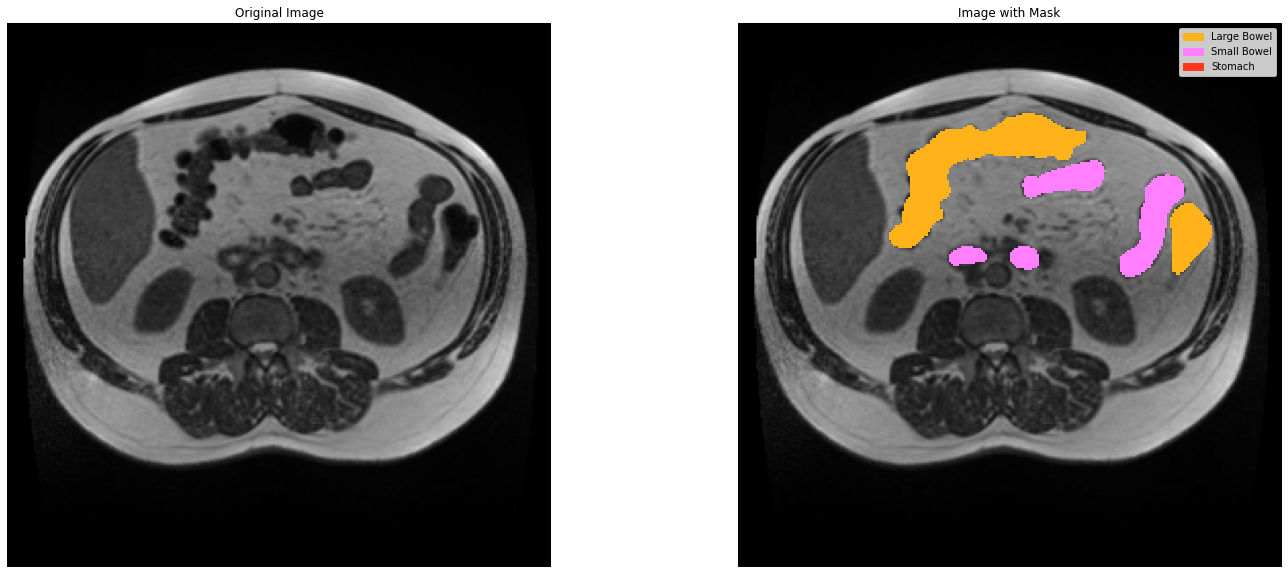

In [ ]:
plot_original_mask(img, mask, alpha=1)